In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

%matplotlib inline
pd.set_option('display.max_columns', 100)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def one_hot(lst, num_class=4) :
    return np.eye(num_class)[lst]

In [3]:
def making_data(csv) :
    activity = pd.read_csv(csv).drop("Unnamed: 0", axis=1)
    label = activity[["acc_id", "label"]]
    
    activity = activity[activity["label"] != "empty"]
    activity = activity.drop("label", axis=1)
    label = label[label["label"] != "empty"]
    
    activity = activity.sort_values(["acc_id","wk"])[['acc_id', 'wk', 'cnt_clear_bam', 'cnt_clear_inzone_light','cnt_clear_inzone_normal', 
                                                  'cnt_clear_inzone_skilled', 'cnt_clear_inzone_solo', 'cnt_clear_raid', 'cnt_clear_raid_light',
                                                  'cnt_dt', 'cnt_enter_bam', 'cnt_enter_inzone_light', 'cnt_enter_inzone_normal', 
                                                  'cnt_enter_inzone_skilled', 'cnt_enter_inzone_solo', 'cnt_enter_raid', 'cnt_enter_raid_light',
                                                  'cnt_use_buffitem', 'district_chat', 'duel_cnt', 'duel_win', 'faction_chat', 'game_combat_time', 
                                                  'gathering_cnt', 'get_money','guild_chat', 'item_hongmun', 'making_cnt', 'normal_chat', 
                                                  'npc_exp', 'npc_hongmun', 'party_chat', 'partybattle_cnt', 'partybattle_win', 'play_time', 
                                                  'quest_exp', 'quest_hongmun', 'whisper_chat','first_week', 'payment_amount']]
    label = label.sort_values("acc_id")
    
    label_lst = sorted(list(set([tuple(x) for x in label.values])))
    label = pd.DataFrame(label_lst, columns = ["acc_id", "label"])
    
    activity1 = activity[activity["wk"]==1].drop(["acc_id", "wk"], axis=1)
    activity2 = activity[activity["wk"]==2].drop(["acc_id", "wk"], axis=1)
    activity3 = activity[activity["wk"]==3].drop(["acc_id", "wk"], axis=1)
    activity4 = activity[activity["wk"]==4].drop(["acc_id", "wk"], axis=1)
    activity5 = activity[activity["wk"]==5].drop(["acc_id", "wk"], axis=1)
    activity6 = activity[activity["wk"]==6].drop(["acc_id", "wk"], axis=1)
    activity7 = activity[activity["wk"]==7].drop(["acc_id", "wk"], axis=1)
    activity8 = activity[activity["wk"]==8].drop(["acc_id", "wk"], axis=1)
    
    activity = np.concatenate([activity1.values, activity2.values, activity3.values, activity4.values,
                               activity5.values, activity6.values, activity7.values, activity8.values], axis=1)
    
    label_dic = {"week":0 , "month" :1, "2month":2, "retained":3}

    label2 = label.sort_values(by="acc_id")
    label2["label"] = label2["label"].map(lambda x : label_dic[x])
    
    total_lst = activity
    label_dic = label2.label.tolist()
    total_label = one_hot(label_dic)
    
    return total_lst, total_label

<br></br><br></br><br></br>

In [4]:
total_lst, total_label = making_data("OnlyExpanded.csv")

In [5]:
idx1 = len(total_lst)//5 *4

training_lst = np.array(total_lst[:idx1])
valid_lst = np.array(total_lst[idx1:])

training_label = np.array(total_label[:idx1])
valid_label = np.array(total_label[idx1:])

In [6]:
print(np.array(total_lst).shape)
print(np.array(total_label).shape)

(100000, 304)
(100000, 4)


<br></br><br></br><br></br>

# Model

In [16]:
class MLP() :
    def __init__(self, sess, name):
        self.sess = sess
        self.name = name
        
    
    def build(self, batch_size, input_dim, output_dim, num_layer, num_unit, activation) :
        with tf.variable_scope(self.name) :
            
            ## Setting ##
            # input  : ? x input_length x input_dim
            self.X = tf.placeholder(tf.float32, [None, input_dim])
            self.Y = tf.placeholder(tf.float32, [None, output_dim])
            self.learning_rate =  tf.placeholder(tf.float32)
            self.training = tf.placeholder(tf.bool)
            
            self.batch_size = batch_size
            self.output_dim = output_dim
            self.num_layer = num_layer
            self.num_unit = num_unit
            self.activation = activation
            #############
            
            
            ## MLP ##
            layer = tf.layers.dense(self.X, self.num_unit, self.activation)
            
            for idx in range(self.num_layer-2) :
                norm = tf.contrib.layers.layer_norm(layer)
                relu = tf.nn.relu(norm)
                dense = tf.layers.dense(relu, self.num_unit)
                layer = tf.layers.dropout(dense, training=self.training)
                
            layer = tf.layers.dense(layer, self.output_dim)
            #########################
            
            
            ## Classifier ##
            self.logit = layer
            self.softmax = tf.nn.softmax(self.logit)
            self.softmax_logit = tf.nn.softmax_cross_entropy_with_logits(logits=self.logit, labels=self.Y)
            ################
            
            
            ## Learning ##
            self.cost = tf.reduce_sum(self.softmax_logit)
            
            update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope=self.name)
            with tf.control_dependencies(update_ops):
                self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)
            
            self.prediction = tf.equal(tf.argmax(self.logit, 1), tf.argmax(self.Y, 1))     
            self.accuracy = tf.reduce_mean(tf.cast(self.prediction, tf.float32))    
            ##############
        
        
    def train(self, X_input, Y_input, learning_rate, training=True):
        feed_dict = {self.X: X_input, self.Y: Y_input, self.learning_rate: learning_rate, self.training: training}
        _, cost = self.sess.run([self.optimizer, self.cost], feed_dict=feed_dict)
        
        return _, cost
    
    def predict(self, X_input, training=False):
        feed_dict = {self.X: X_input, self.training: training}
        result = self.sess.run([self.logit], feed_dict=feed_dict)
            
        return result
    
    def evaluate(self, X_input, Y_input):
        size = X_input.shape[0]
            
        total_loss = 0
        total_acc = 0
            
        for idx in range(0, size, self.batch_size):
            X_batch = X_input[idx:idx + batch_size]
            Y_batch = Y_input[idx:idx + batch_size]
            feed_dict = {self.X: X_batch, self.Y: Y_batch, self.training: False}
                
            loss = self.cost
            accuracy = self.accuracy
                
            step_loss, step_acc = self.sess.run([loss, accuracy], feed_dict=feed_dict)
                
            total_loss += step_loss * X_batch.shape[0]
            total_acc += step_acc * X_batch.shape[0]
            
        total_loss /= size
        total_acc /= size
            
        return total_loss, total_acc

In [38]:
tf.reset_default_graph() 

<br></br><br></br><br></br> 

In [39]:
learning_rate1 = 0.02
learning_rate2 = 0.01
learning_rate3 = 0.005
learning_rate4 = 0.001

total_epoch = 100
batch_size = 500
input_dim = np.array(total_lst).shape[1]

In [40]:
idx = 0
model_lst = []

for num_layer in [4,6,8] :
    for num_unit in [256, 512] :
        for activation in [None, tf.nn.relu] :
            print(idx)
            sess = tf.Session()
            model = MLP(sess, "model{}".format(idx))
            model.build(batch_size, input_dim, 4, num_layer, num_unit, activation)
            sess.run(tf.global_variables_initializer())
            
            model_lst.append(model)
            idx +=1
            
tl_ta_vl_va_lst = [[[],[],[],[]]]*len(model_lst)
print("Ready!")

0
1
2
3
4
5
6
7
8
9
10
11
Ready!


In [41]:
print('Learning Started!')
print("")

# train my model
for epoch in range(total_epoch):
    avg_cost = [0]*len(model_lst)
    total_batch = int(len(training_lst) / batch_size)
    idx = 0
    
    if epoch == 0 :
        learning_rate = learning_rate1
    elif epoch == 10 :
        learning_rate = learning_rate2
    elif epoch == 20 :
        learning_rate = learning_rate3
    elif epoch == 80 :
        learning_rate = learning_rate4

    for i in range(total_batch):
        batch_xs, batch_ys = training_lst[idx:idx+batch_size],training_label[idx:idx+batch_size]
        
        for model_num, model in enumerate(model_lst) :
            _, c = model.train(batch_xs, batch_ys, learning_rate)
            avg_cost[model_num] += c / total_batch
        
        idx += batch_size
        if i%10 == 0 :
            print("log :", i)
            
    #train/valid cost & acc
    print("***epoch*** : ", epoch)
    for model_num, model in enumerate(model_lst) :
        train_cost, train_acc = model.evaluate(training_lst, training_label)
        valid_cost, valid_acc = model.evaluate(valid_lst, valid_label)

        tl_ta_vl_va_lst[model_num][0].append(train_cost)
        tl_ta_vl_va_lst[model_num][1].append(train_acc)
        tl_ta_vl_va_lst[model_num][2].append(valid_cost)
        tl_ta_vl_va_lst[model_num][3].append(valid_acc)

        print("-- train {:.5f}({:.1f}%), valid{:.5f}({:.1f}%)".format(train_cost, train_acc*100, valid_cost, valid_acc*100))
    
    for model in model_lst :
        print('Accuracy:', model.evaluate(valid_lst, valid_label)[1])
    print(" ")

print("")
print('Learning Finished!')

Learning Started!

log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  0
-- train 476.79624(61.0%), valid474.73653(61.1%)
-- train 481.91592(61.9%), valid479.40338(62.1%)
-- train 492.74388(60.8%), valid488.13340(61.3%)
-- train 476.81699(61.2%), valid474.72239(61.5%)
-- train 503.02929(59.9%), valid499.98632(59.9%)
-- train 499.75208(60.4%), valid495.21351(60.5%)
-- train 776.49624(42.6%), valid771.76493(42.9%)
-- train 544.43315(59.8%), valid538.90877(59.9%)
-- train 696.12667(25.0%), valid695.85507(25.1%)
-- train 693.86040(24.9%), valid693.67781(25.3%)
-- train 693.22498(24.9%), valid693.20151(25.3%)
-- train 700.05861(25.1%), valid700.75866(24.7%)
Accuracy: 0.6106000021100044
Accuracy: 0.6207500025629997
Accuracy: 0.612550000846386
Accuracy: 0.6146000027656555
Accuracy: 0.598599998652935
Accuracy: 0.6047000005841255
Accuracy: 0.4290000021457672
Accuracy: 0.59939999580383

-- train 508.37203(64.9%), valid530.80953(64.6%)
-- train 506.82898(67.2%), valid529.47605(66.8%)
-- train 481.19558(66.6%), valid488.24906(66.6%)
-- train 444.90596(65.8%), valid447.52867(65.8%)
-- train 693.99204(24.9%), valid693.79684(25.3%)
-- train 460.07543(66.0%), valid467.72991(66.0%)
Accuracy: 0.6597999975085258
Accuracy: 0.6421499967575073
Accuracy: 0.6495499968528747
Accuracy: 0.6739499971270562
Accuracy: 0.6681999996304512
Accuracy: 0.6735999971628189
Accuracy: 0.6461500033736229
Accuracy: 0.6680000007152558
Accuracy: 0.6660500019788742
Accuracy: 0.6579999998211861
Accuracy: 0.25285000056028367
Accuracy: 0.6597499996423721
 
log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  8
-- train 433.48201(67.2%), valid453.44921(66.4%)
-- train 437.83792(64.9%), valid466.46074(64.3%)
-- train 458.07476(66.3%), valid483.16418(65.5%)
-- train 419.01777(67.8%), valid443.47624(

Accuracy: 0.6830999985337257
Accuracy: 0.6712500005960464
Accuracy: 0.6757499948143959
Accuracy: 0.6079500004649162
Accuracy: 0.6786499977111816
 
log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  15
-- train 388.54073(69.0%), valid420.55169(68.2%)
-- train 394.57812(69.0%), valid441.33371(68.1%)
-- train 418.39589(69.0%), valid463.08857(68.2%)
-- train 414.29059(69.4%), valid467.35071(68.5%)
-- train 383.86316(68.5%), valid402.66440(67.7%)
-- train 383.00585(69.1%), valid408.11392(68.3%)
-- train 394.73691(67.6%), valid431.08321(67.0%)
-- train 493.97094(69.2%), valid544.66299(68.3%)
-- train 433.53027(67.6%), valid446.04992(67.5%)
-- train 401.74560(67.9%), valid412.65252(67.6%)
-- train 505.28133(60.1%), valid511.23877(59.7%)
-- train 463.24145(68.1%), valid482.16413(68.0%)
Accuracy: 0.6816499963402748
Accuracy: 0.6809499964118004
Accuracy: 0.6815499976277352
Accuracy: 0

-- train 354.41405(69.0%), valid381.37312(68.3%)
-- train 384.25298(69.9%), valid435.51290(68.7%)
-- train 392.48410(68.4%), valid451.16511(67.0%)
-- train 429.61560(70.3%), valid520.10793(68.4%)
-- train 413.42328(68.3%), valid432.57259(67.8%)
-- train 383.77029(68.1%), valid400.47521(67.8%)
-- train 471.79481(67.8%), valid491.44743(67.3%)
-- train 437.38600(68.9%), valid471.03804(68.4%)
Accuracy: 0.6832000032067299
Accuracy: 0.6793500021100044
Accuracy: 0.6800999939441681
Accuracy: 0.6819499954581261
Accuracy: 0.6833000004291534
Accuracy: 0.6873499944806098
Accuracy: 0.6698499992489815
Accuracy: 0.6841999977827072
Accuracy: 0.6777500003576279
Accuracy: 0.6779499992728233
Accuracy: 0.6734500020742417
Accuracy: 0.6843999966979026
 
log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  23
-- train 390.13431(69.1%), valid453.22797(67.6%)
-- train 388.91398(69.1%), valid477.89113(

Accuracy: 0.6809999957680702
Accuracy: 0.6832999989390374
Accuracy: 0.6876499995589256
Accuracy: 0.6832500025629997
Accuracy: 0.6862999960780144
Accuracy: 0.6804499983787536
Accuracy: 0.6805499970912934
Accuracy: 0.6759499967098236
Accuracy: 0.6871999993920326
 
log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  30
-- train 395.14033(69.2%), valid480.79468(67.5%)
-- train 378.06700(70.6%), valid500.39638(68.3%)
-- train 380.58615(71.1%), valid496.18271(69.1%)
-- train 398.69703(70.8%), valid564.65764(68.3%)
-- train 353.18530(69.3%), valid386.72831(68.3%)
-- train 370.11438(70.5%), valid440.58373(68.6%)
-- train 379.17169(70.0%), valid458.32163(68.0%)
-- train 409.70654(71.3%), valid537.20737(68.6%)
-- train 411.29448(68.9%), valid432.86013(68.2%)
-- train 369.64045(68.8%), valid390.77894(68.4%)
-- train 471.65110(69.0%), valid504.70890(68.1%)
-- train 425.82089(69.8%), vali

-- train 375.41853(70.8%), valid539.52808(68.1%)
-- train 417.92033(70.8%), valid589.16150(68.4%)
-- train 391.39719(70.6%), valid618.64982(67.3%)
-- train 350.26845(69.5%), valid390.69850(68.1%)
-- train 368.49764(70.9%), valid452.07718(68.6%)
-- train 352.20175(71.5%), valid460.27223(68.8%)
-- train 404.06750(72.0%), valid553.24654(68.9%)
-- train 409.85963(68.7%), valid434.42911(67.6%)
-- train 365.03995(69.3%), valid394.25664(68.5%)
-- train 428.84168(70.1%), valid476.22696(68.9%)
-- train 413.18713(70.3%), valid481.06590(68.9%)
Accuracy: 0.6869500041007995
Accuracy: 0.6806000038981438
Accuracy: 0.6836000010371208
Accuracy: 0.6734000012278557
Accuracy: 0.6807000011205673
Accuracy: 0.6864999935030938
Accuracy: 0.6881999969482422
Accuracy: 0.6892999961972237
Accuracy: 0.6762499943375587
Accuracy: 0.6848499998450279
Accuracy: 0.6890499979257584
Accuracy: 0.6891999959945678
 
log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
lo

-- train 384.50313(70.8%), valid458.37297(69.0%)
Accuracy: 0.6786999985575676
Accuracy: 0.6725000023841858
Accuracy: 0.6828499972820282
Accuracy: 0.6768000036478042
Accuracy: 0.6897499963641167
Accuracy: 0.6884500056505203
Accuracy: 0.6876499995589256
Accuracy: 0.6857499942183495
Accuracy: 0.6777499958872795
Accuracy: 0.6820999994874001
Accuracy: 0.6871999964118004
Accuracy: 0.6904999986290932
 
log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  45
-- train 369.93094(71.1%), valid511.98566(68.8%)
-- train 349.91955(71.8%), valid540.70205(68.5%)
-- train 398.25410(70.9%), valid631.15319(68.1%)
-- train 426.40282(70.8%), valid772.68507(67.6%)
-- train 350.92593(70.4%), valid405.34723(68.6%)
-- train 357.04663(71.7%), valid461.78625(69.1%)
-- train 356.73993(71.4%), valid489.80966(68.3%)
-- train 361.65899(72.8%), valid556.79503(68.9%)
-- train 395.68519(69.4%), valid426.69303(

log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  52
-- train 379.73835(70.6%), valid545.42342(67.5%)
-- train 355.35166(72.3%), valid588.55718(68.5%)
-- train 386.50924(71.2%), valid687.03867(68.1%)
-- train 407.86078(72.1%), valid783.07927(68.1%)
-- train 339.22206(70.2%), valid402.53184(68.5%)
-- train 365.46891(71.7%), valid481.95075(69.0%)
-- train 357.79380(72.6%), valid524.40746(69.0%)
-- train 361.19495(73.2%), valid580.67336(68.9%)
-- train 418.63032(69.1%), valid456.51970(67.8%)
-- train 366.76187(69.7%), valid407.69839(68.4%)
-- train 435.92965(70.2%), valid525.23549(68.5%)
-- train 392.20227(71.6%), valid504.28387(69.3%)
Accuracy: 0.6747000008821488
Accuracy: 0.6851999938488007
Accuracy: 0.6814499989151954
Accuracy: 0.6805500000715256
Accuracy: 0.6846999958157539
Accuracy: 0.6896500021219254
Accuracy: 0.6903999969363213
Accuracy: 0.6892999976873397
Accuracy: 0.6775499984622002
Accuracy: 0.6842499986290932
Accuracy: 0.68494999706745

-- train 391.48800(68.9%), valid433.83245(67.3%)
-- train 366.65847(69.9%), valid412.23658(68.2%)
-- train 416.61956(70.0%), valid517.39165(67.8%)
-- train 400.70444(71.4%), valid527.84373(68.8%)
Accuracy: 0.6804999977350235
Accuracy: 0.6742999970912933
Accuracy: 0.6795499995350838
Accuracy: 0.6671000063419342
Accuracy: 0.6870999962091446
Accuracy: 0.6884999975562096
Accuracy: 0.684749998152256
Accuracy: 0.6906499996781349
Accuracy: 0.6732499971985817
Accuracy: 0.682049997150898
Accuracy: 0.6782000005245209
Accuracy: 0.6884999990463256
 
log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  60
-- train 378.51506(71.0%), valid584.90904(67.7%)
-- train 346.38165(72.7%), valid614.90878(68.3%)
-- train 366.78191(71.8%), valid764.18614(68.1%)
-- train 405.64939(72.8%), valid844.25281(68.3%)
-- train 341.59116(71.5%), valid420.08229(69.2%)
-- train 361.60567(71.9%), valid500.47762(68

Accuracy: 0.6745000004768371
Accuracy: 0.692749997973442
 
log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  67
-- train 367.71008(72.0%), valid615.34733(68.5%)
-- train 356.58027(72.8%), valid634.53723(68.1%)
-- train 371.20774(72.0%), valid775.46065(67.7%)
-- train 393.35187(71.9%), valid859.53586(67.1%)
-- train 332.76869(71.4%), valid426.56834(68.7%)
-- train 359.05743(71.7%), valid522.65899(67.8%)
-- train 356.58998(73.1%), valid569.89215(69.0%)
-- train 359.16097(73.9%), valid674.88143(69.1%)
-- train 392.55484(70.1%), valid443.99477(68.6%)
-- train 364.39779(70.5%), valid416.89294(68.5%)
-- train 427.02114(70.8%), valid551.80883(68.3%)
-- train 387.01378(72.4%), valid540.79056(69.2%)
Accuracy: 0.6845499947667122
Accuracy: 0.6812999963760376
Accuracy: 0.6773499950766564
Accuracy: 0.6706999972462654
Accuracy: 0.6865999951958657
Accuracy: 0.6784500002861023
Accuracy: 0.

-- train 350.25430(72.7%), valid504.17928(69.2%)
-- train 342.82750(73.2%), valid568.39260(68.9%)
-- train 340.38896(74.9%), valid710.53436(69.3%)
-- train 388.79884(69.3%), valid440.36526(67.5%)
-- train 346.28873(70.9%), valid408.71997(68.4%)
-- train 434.80260(71.6%), valid588.12820(68.5%)
-- train 396.93219(72.1%), valid557.02078(68.9%)
Accuracy: 0.6800499960780144
Accuracy: 0.6861999958753586
Accuracy: 0.6768999993801117
Accuracy: 0.6745499968528748
Accuracy: 0.685499994456768
Accuracy: 0.691949999332428
Accuracy: 0.6887999981641769
Accuracy: 0.6928999975323678
Accuracy: 0.6752499982714653
Accuracy: 0.6836499944329262
Accuracy: 0.6854500055313111
Accuracy: 0.6885499984025956
 
log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  75
-- train 374.66875(72.8%), valid659.42150(69.0%)
-- train 355.42884(73.2%), valid657.04547(68.5%)
-- train 339.73271(72.5%), valid805.61497(67

Accuracy: 0.6887999981641769
Accuracy: 0.6904999986290932
Accuracy: 0.696799997985363
Accuracy: 0.6854999959468842
Accuracy: 0.6894999966025352
Accuracy: 0.6870499953627587
Accuracy: 0.6939500048756599
 
log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  82
-- train 358.05710(73.9%), valid711.80459(69.0%)
-- train 328.89311(74.6%), valid692.35977(68.9%)
-- train 320.61440(75.0%), valid934.59537(69.2%)
-- train 344.36784(75.3%), valid938.70865(69.4%)
-- train 337.32403(72.5%), valid444.22530(69.2%)
-- train 324.36025(73.9%), valid534.88378(69.0%)
-- train 313.11883(74.7%), valid612.50965(68.9%)
-- train 316.99561(75.8%), valid744.67673(69.8%)
-- train 364.49539(70.6%), valid421.16772(68.5%)
-- train 340.55824(71.8%), valid408.19423(68.8%)
-- train 404.36437(72.6%), valid588.03235(68.7%)
-- train 363.96569(73.3%), valid566.82186(69.4%)
Accuracy: 0.6904000014066696
Accuracy: 0.

-- train 329.54378(74.9%), valid1080.82065(68.8%)
-- train 361.08450(75.5%), valid1074.78754(69.2%)
-- train 334.99424(72.6%), valid451.88836(69.0%)
-- train 315.50295(74.2%), valid539.70079(69.1%)
-- train 311.50914(75.2%), valid642.27539(69.4%)
-- train 319.35290(76.0%), valid778.54356(69.7%)
-- train 361.70089(70.6%), valid424.01964(68.4%)
-- train 336.09947(71.9%), valid408.81865(68.9%)
-- train 424.74288(72.7%), valid632.02093(68.7%)
-- train 369.50372(73.4%), valid587.75522(69.4%)
Accuracy: 0.6881500035524368
Accuracy: 0.6891999989748001
Accuracy: 0.6883999988436699
Accuracy: 0.6923999965190888
Accuracy: 0.6901999980211257
Accuracy: 0.691449998319149
Accuracy: 0.6940499976277351
Accuracy: 0.6967999950051308
Accuracy: 0.6836999967694283
Accuracy: 0.6894999980926514
Accuracy: 0.6868999928236008
Accuracy: 0.6940999984741211
 
log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch**

Accuracy: 0.6907999977469444
Accuracy: 0.691299992799759
Accuracy: 0.6898499965667725
Accuracy: 0.6936999976634979
Accuracy: 0.692849999666214
Accuracy: 0.6921999976038933
Accuracy: 0.6910999968647957
Accuracy: 0.6987999975681305
Accuracy: 0.6861999988555908
Accuracy: 0.6901499986648559
Accuracy: 0.6869000032544136
Accuracy: 0.6945500016212464
 
log : 0
log : 10
log : 20
log : 30
log : 40
log : 50
log : 60
log : 70
log : 80
log : 90
log : 100
log : 110
log : 120
log : 130
log : 140
log : 150
***epoch*** :  97
-- train 355.56817(74.5%), valid796.94002(69.3%)
-- train 334.85065(75.0%), valid775.66746(68.9%)
-- train 327.06009(75.3%), valid1158.41424(69.0%)
-- train 358.67857(75.8%), valid1169.40470(69.3%)
-- train 327.09586(72.9%), valid446.50804(69.3%)
-- train 316.92741(74.4%), valid556.79398(69.2%)
-- train 312.96863(75.0%), valid666.16073(68.9%)
-- train 316.39880(76.1%), valid814.75056(69.6%)
-- train 368.37655(70.5%), valid429.99020(68.5%)
-- train 337.48294(72.0%), valid413.41049(

 <br></br><br></br><br></br> 

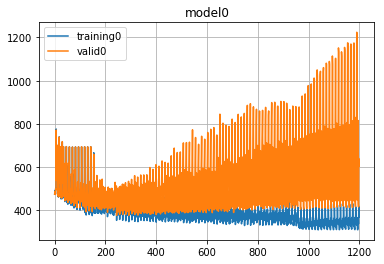

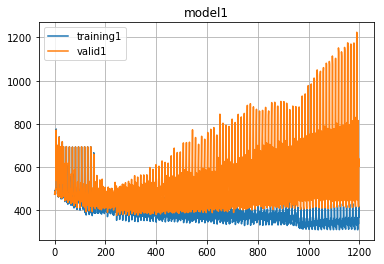

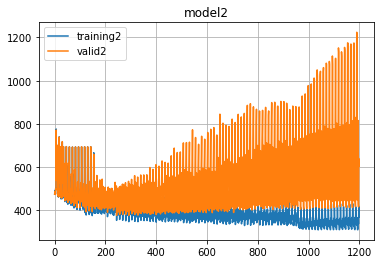

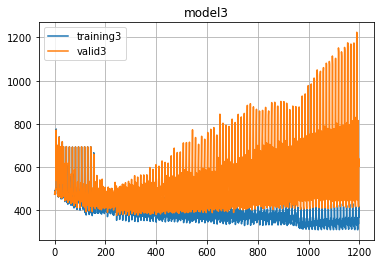

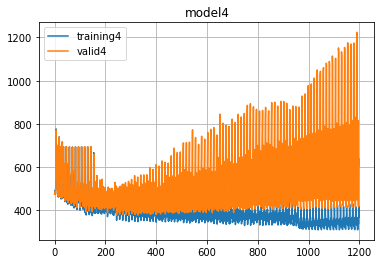

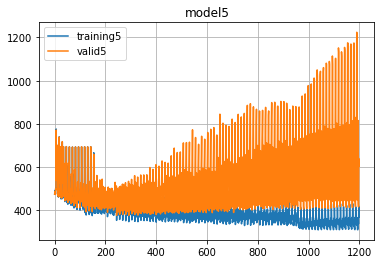

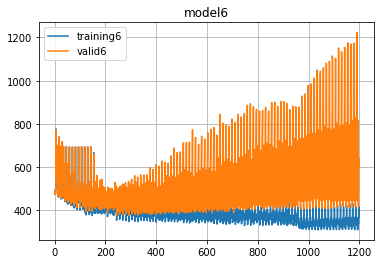

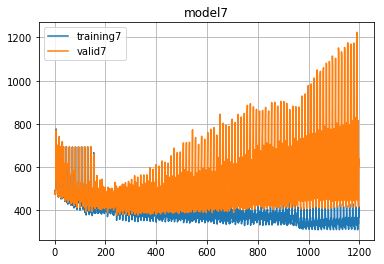

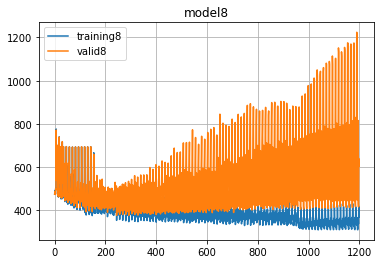

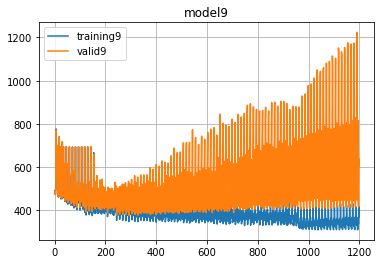

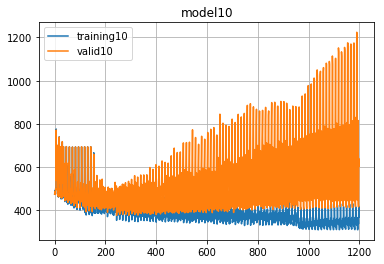

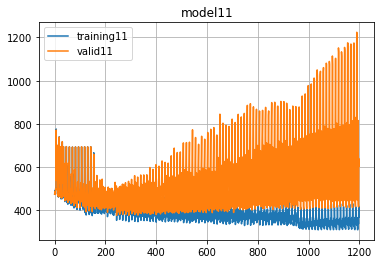

In [42]:
for idx in range(len(model_lst)) :
    plt.plot(tl_ta_vl_va_lst[idx][0], label='training'+str(idx))
    plt.plot(tl_ta_vl_va_lst[idx][2], label='valid'+str(idx))
    plt.title("model"+str(idx))
    plt.grid("on")
    plt.legend()
    plt.show()

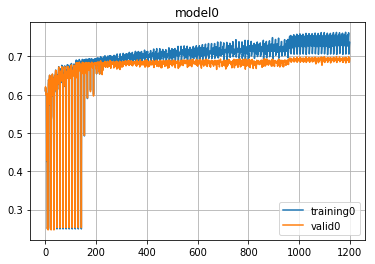

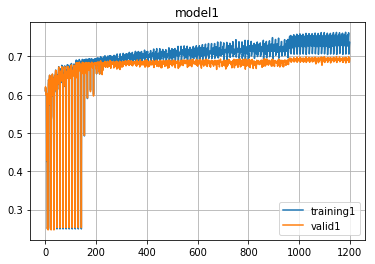

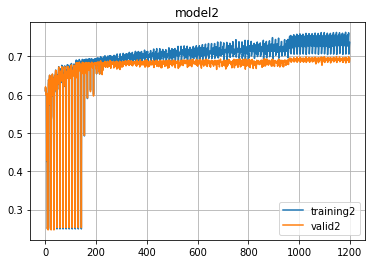

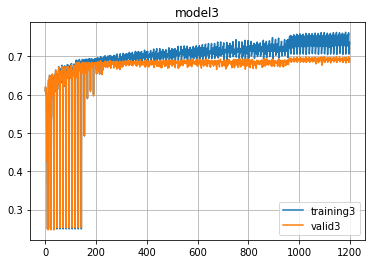

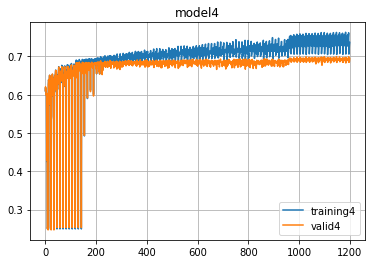

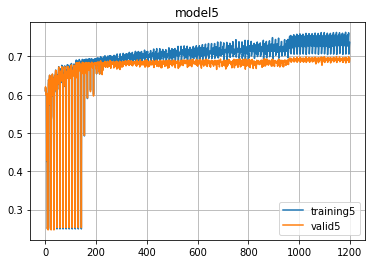

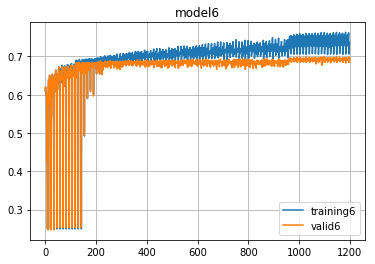

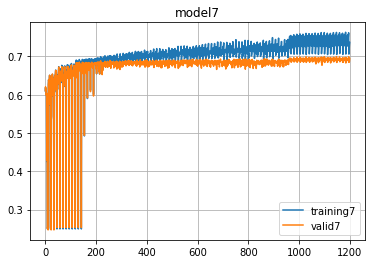

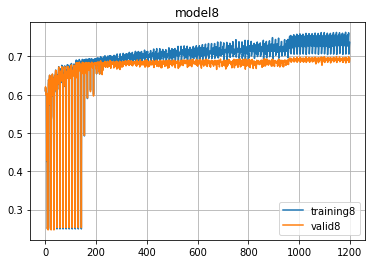

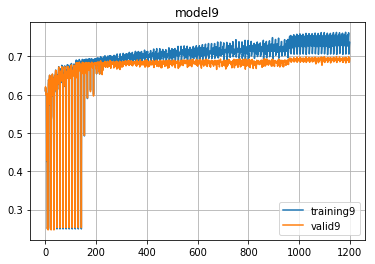

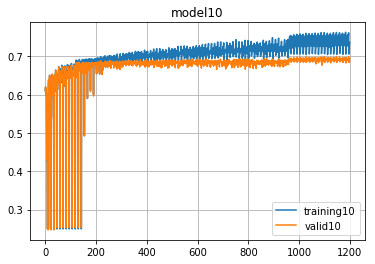

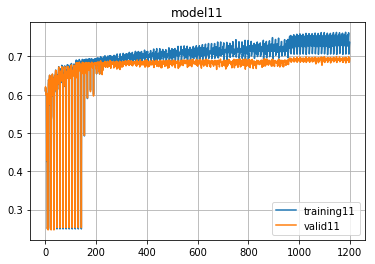

In [43]:
for idx in range(len(model_lst)) :
    plt.plot(tl_ta_vl_va_lst[idx][1], label='training'+str(idx))
    plt.plot(tl_ta_vl_va_lst[idx][3], label='valid'+str(idx))
    plt.title("model"+str(idx))
    plt.grid("on")
    plt.legend()
    plt.show()

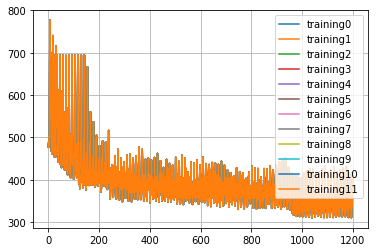

In [44]:
for idx in range(len(model_lst)) :
    plt.plot(tl_ta_vl_va_lst[idx][0], label='training'+str(idx))
    
plt.grid("on")
plt.legend()
plt.show()

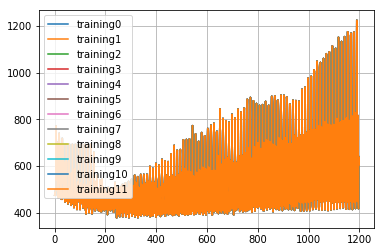

In [45]:
for idx in range(len(model_lst)) :
    plt.plot(tl_ta_vl_va_lst[idx][2], label='training'+str(idx))
    
plt.grid("on")
plt.legend()
plt.show()

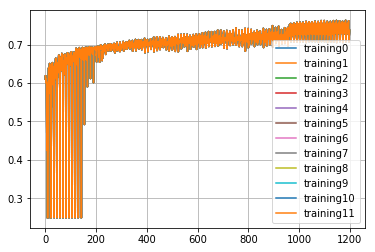

In [46]:
for idx in range(len(model_lst)) :
    plt.plot(tl_ta_vl_va_lst[idx][1], label='training'+str(idx))
    
plt.grid("on")
plt.legend()
plt.show()

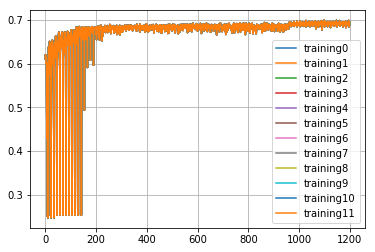

In [47]:
for idx in range(len(model_lst)) :
    plt.plot(tl_ta_vl_va_lst[idx][3], label='training'+str(idx))
    
plt.grid("on")
plt.legend()
plt.show()

<br></br><br></br><br></br>  

In [ ]:
#tf.reset_default_graph() 

In [364]:
saver = tf.train.Saver()

for idx, model in enumerate(model_lst) :
    saver.save(model.sess, './model/MLP_default_model_{}'.format(idx))

print("Saved!")

'./advanced_RNN/original_user_vector/original'

<br></br><br></br><br></br>

# Test

In [45]:
def making_data(csv) :
    activity = pd.read_csv(csv).drop("Unnamed: 0", axis=1)
    
    activity = activity[activity["label"] == "empty"]
    activity = activity.drop("label", axis=1)
    
    activity = activity.sort_values(["acc_id","wk"])[['acc_id', 'wk', 'cnt_clear_bam', 'cnt_clear_inzone_light','cnt_clear_inzone_normal', 
                                                  'cnt_clear_inzone_skilled', 'cnt_clear_inzone_solo', 'cnt_clear_raid', 'cnt_clear_raid_light',
                                                  'cnt_dt', 'cnt_enter_bam', 'cnt_enter_inzone_light', 'cnt_enter_inzone_normal', 
                                                  'cnt_enter_inzone_skilled', 'cnt_enter_inzone_solo', 'cnt_enter_raid', 'cnt_enter_raid_light',
                                                  'cnt_use_buffitem', 'district_chat', 'duel_cnt', 'duel_win', 'faction_chat', 'game_combat_time', 
                                                  'gathering_cnt', 'get_money','guild_chat', 'item_hongmun', 'making_cnt', 'normal_chat', 
                                                  'npc_exp', 'npc_hongmun', 'party_chat', 'partybattle_cnt', 'partybattle_win', 'play_time', 
                                                  'quest_exp', 'quest_hongmun', 'whisper_chat','first_week', 'payment_amount']]
    
    activity1 = activity[activity["wk"]==1].drop(["acc_id", "wk"], axis=1)
    activity2 = activity[activity["wk"]==2].drop(["acc_id", "wk"], axis=1)
    activity3 = activity[activity["wk"]==3].drop(["acc_id", "wk"], axis=1)
    activity4 = activity[activity["wk"]==4].drop(["acc_id", "wk"], axis=1)
    activity5 = activity[activity["wk"]==5].drop(["acc_id", "wk"], axis=1)
    activity6 = activity[activity["wk"]==6].drop(["acc_id", "wk"], axis=1)
    activity7 = activity[activity["wk"]==7].drop(["acc_id", "wk"], axis=1)
    activity8 = activity[activity["wk"]==8].drop(["acc_id", "wk"], axis=1)
    
    label = activity["acc_id"].values
    activity = np.concatenate([activity1.values, activity2.values, activity3.values, activity4.values,
                               activity5.values, activity6.values, activity7.values, activity8.values], axis=1)

    total_lst = activity
    return total_lst, label

In [50]:
test_data, test_acc_id = making_data("OnlyExpanded.csv")

In [51]:
print(test_data.shape)

(40000, 304)


<br></br><br></br><br></br> 

# Predict

In [ ]:
result = []
for model in model_lst :
    result.append(np.argmax(model.predict(test_data), axis=2)) 
    
result = list(map(lambda x : x.tolist()[0], result))
for r_lst in result :
    print("week: {}, month: {}, 2month: {}, retained: {}".format(r_lst.count(0), r_lst.count(1), r_lst.count(2), r_lst.count(3)))

In [ ]:
label_df = pd.DataFrame(sorted(list(set(list(test_acc_id))))).rename(columns = {0 : "acc_id"})
result_df = pd.DataFrame(result).T

In [ ]:
result_df2 = pd.concat([label_df, result_df], axis=1)
result_df2.head()